In [ ]:
##<script>
##  jQuery(document).ready(function($) {  
##  
##  $(window).on('load', function(){
##    $('#preloader').fadeOut('slow',function(){$(this).remove();});
##  });
##  
##  });
##</script>
##
##<style type="text/css">
##  div#preloader { position: fixed; 
##      left: 0; 
##      top: 0; 
##      z-index: 999; 
##      width: 100%; 
##      height: 100%; 
##      overflow: visible; 
##      background: #fff url('http://preloaders.net/preloaders/720/Moving%20line.gif') no-repeat center center; 
##  }
##
##</style>
##
##<div id="preloader">
##
##</div>

# Choice Variability Analysis
### Dec 2018

<a id='load'></a>
## 1. Load data and excluding participants
----------------------------------------------------------------

Participants 6, 33, 7, 17, 25, 30 had to be excluded. Additionally, it was checked that trials in which participants did not fixate in any of the items were skipped. 
Therefore, 7 participants have been excluded.

Total number subjects = 40
Number of subjects remaining =33


Extra Removal= particpants 2 and 35 are removeed due to problems in pair presentations

In [13]:
# Load data all participants
#data_exp1 = pd.read_csv('/Users/pradyumna/Documents/gitDocs/FF2018/Output/DataFoodFramingNotebook_v1.csv') 
data_exp1 = pd.read_csv('/Users/pradyumna/Documents/GiTs/FF2018/Output/DataFoodFramingNotebook_v1.csv') 




for i in [6, 7, 17, 25, 30, 33, 2 , 35]:
    data_exp1 = data_exp1[(data_exp1.Part != i)]
print (data_exp1["Part"].unique())
print ('Number of participants: ' + str(len(data_exp1["Part"].unique())))

[ 1  3  4  5  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 26 27 28 29
 31 32 34 36 37 38 39]
Number of participants: 31


In [14]:
# Unify the names
data_exp1=data_exp1.rename(index=str, columns={"ChosenITM":"Choice", 
                              "ChoiceRT":"RT",
                             "RValue":"RVal",
                             "LValue":"LVal",
                             "zRValue":"zRVal",
                             "zLValue":"zLVal",                    
                             "tDDT":"DDT",
                             "absDDT":"zAbsDDT",
                             "lIA_DT":"LDwellTime",
                             "rIA_DT":"RDwellTime",
                             "tGSF":"GSF",
                             "lastFixat":"LastFixat",
                             "DV":"DVal",
                             "zDV":"zDVal",
                             "absDV":"AbsDVal",
                             "zAbsDV":"zAbsDVal",                    
                             "zChoiceRT":"zRT",
                             "FamCh":"ChosenFam",
                              "FamUnCh":"UnchosenFam",
                              "ValCh":"ChosenVal",
                              "ValUnCh":"UnchosenVal",
                             "zFamCh":"zChosenFam",
                              "zFamUnCh":"zUnchosenFam",
                              "zValCh":"zChosenVal",
                              "zValUnCh":"zUnchosenVal",                   
                              "GSFMedSplit":"GSFSplit",
                            "DDTMedSplit":"DDTSplit"})
data_exp1  = data_exp1.drop(['Unnamed: 0'],axis=1)


## Load relevant lists and generate pair variability information

In [15]:
participants = data_exp1["Part"].unique()
pairsIds = data_exp1["PairID"].unique()

In [16]:
pairsID_matrix = []
pairsID_matrix_aux= []

for i in participants:
    parID_variab = [0]*len(pairsIds) # Initialize vector with number of items per participant
    # Use code 0 : not available (or equal value for both options) ; 1 : Consistent Correct; 2: Consistent Incorrect ; 3: Inconsistent Correct-Incorrect, 4 : Inconsistent Incorrect-Correct   
    for j in [1,2]:
        datBlock = data_exp1.loc[(data_exp1['BlockCond'] == j) & (data_exp1['Part'] == i)]
        
        pairID_info = []
        pairsID_TotConfPair = []

        for k in range(0,len(pairsIds)):
            datPairID= datBlock.loc[(data_exp1['PairID'] == k+1)]            
            pairID_info.append(k+1)
            
            #Add measure of total confidence (confidence value right and value left)
            pairsID_TotConfPair.append(datPairID.zRValConfBDM[0] + datPairID.zLValConfBDM[0])

            # if we have that the pair is bigger or shorter.
            if len(datPairID) != 2:
                continue
            
            if sum(datPairID.Choice.values) == 1: # This means that one of the answers was right and the other left, which is expected in the case the choice is consistent and correct
                    if sum(datPairID.Correct.values) == 2:  # if both are correct
                        parID_variab[k] = 1
                    elif sum(datPairID.Correct.values) == 0: # if both are incorrect
                        parID_variab[k] = 2
            else: # for the case that choice is equal (both right or both left choice), but one of them is incorrect  
                    if (datPairID.Correct.values[0] == 1) & (datPairID.Correct.values[1] == 0):  # first one is correct
                        parID_variab[k] = 3
                    elif (datPairID.Correct.values[0] == 0) & (datPairID.Correct.values[1] == 1): # second one is correct
                        parID_variab[k] = 4
                        
            
        part_info = [i]*len(pairsIds)
        block_info = [j]*len(pairsIds)
        pairsID_matrix_aux= np.column_stack(( part_info, block_info,pairID_info,parID_variab,pairsID_TotConfPair))
        
        for z in range(len(pairsID_matrix_aux)):    
            pairsID_matrix.append(pairsID_matrix_aux[z])

pairID_state = pd.DataFrame(pairsID_matrix,columns = ['Part', 'Block', 'PairID', 'PairID_outcome', 'PairID_TotConf'])

## Eliminate pairs where the pairID information is defective or lost (PairID_outcome=0)

In [17]:
pairID_state  = pairID_state[pairID_state.PairID_outcome != 0]

## Add variability column 

In [18]:
pairID_state['variability'] = ((pairID_state['PairID_outcome'] == 3) | (pairID_state['PairID_outcome'] == 4)).astype('int') # 1 if inconsistent 0 if consistent
#pairID_state['variability'] = ((pairID_state['PairID_outcome'] == 1)).astype('int') # 1 if consistent correct 0 if not

## Separate Like and Dislike


In [19]:
pairID_state_like = pairID_state.loc[(pairID_state['Block'] == 1) ]
pairID_state_dislike = pairID_state.loc[(pairID_state['Block'] == 2)]

## Eliminate pairs not available in both frames

In [20]:
lost_pairID = [0]*len(participants) # Initialize vector with number of items per participant
part_count = 0
for p in participants:
     
    array1 = pairID_state_like.loc[(pairID_state_like['Part'] == p)].PairID.unique()
    array2 = pairID_state_dislike.loc[(pairID_state_dislike['Part'] == p)].PairID.unique()
    
    if len(array1)<len(array2):
        array1 = pairID_state_dislike.loc[(pairID_state_dislike['Part'] == p)].PairID.unique()
        array2 = pairID_state_like.loc[(pairID_state_like['Part'] == p)].PairID.unique()
    
    #check unique data
    unique = [];
    for i in  range(len(array1)):
        found = False
     
        for j in range(len(array2)):
             if(array1[i] == array2[j]):
                found = True                
                break
                
        if found == False:
                # Eliminate pairs not available in both frames. 
                pairID_state_like = pairID_state_like[(pairID_state_like['Part'] != p) | ((pairID_state_like['Part'] == p) & (pairID_state_like['PairID'] != array1[i]))]
                pairID_state_dislike = pairID_state_dislike[(pairID_state_dislike['Part'] != p) | ((pairID_state_dislike['Part'] == p) & (pairID_state_dislike['PairID'] != array1[i]))]
                unique.append(array1[i])
    
    
    lost_pairID[part_count] = unique
    part_count += 1
    
 #   # Eliminate pairs where the pairID information is defective (PairID_outcome=0)
 #   pairID_state  = pairID_state[pairID_state.PairID_outcome != 0]        

## 2.Relationship between variability and total (BDM) confidence for each particular pair

PairID_TotConf considers the total (z-scored per participant) confidence reported during BDM value report for each item.
Significant negative effect of PairID_TotConf over variability (HIgher the confidence in the value given to the item, the less variable will be the choice). Separating per block, we found that this negative effeect is significant only for the like case.
As Polania et al (2019) defines variability in value ratings (since they have two independent value rating for the items) , I think we can use confidence BDM ratings as a proxy for that variability.
From  Polania : " Choice consistency also depended on the variability in the value ratings: the higher this variability for the items on a given trial, the less consistent the decision". This could be translated in our case to : "the lower the confidence in BDM ratings for both items in a trial, the higher the variability in choice". That's the significant effect we observe in the regression.

---------------------------------------------------------

In [21]:
%R -i pairID_state -i pairID_state_like -i pairID_state_dislike

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [22]:
%%R
library(lme4)
library(car)
library(optimx)
library(ggplot2)
library(MASS)
library(broom)
library(dplyr)
library(reshape2)
library(arm)
library(multcomp)
library(pbkrtest)


Call:
glm(formula = variability ~ PairID_TotConf, family = binomial(link = "logit"), 
    data = pairID_state)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6383  -0.5238  -0.5059  -0.4907   2.1318  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -1.95848    0.05027 -38.960   <2e-16 ***
PairID_TotConf -0.07034    0.03504  -2.008   0.0447 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2750.1  on 3666  degrees of freedom
Residual deviance: 2746.1  on 3665  degrees of freedom
AIC: 2750.1

Number of Fisher Scoring iterations: 4



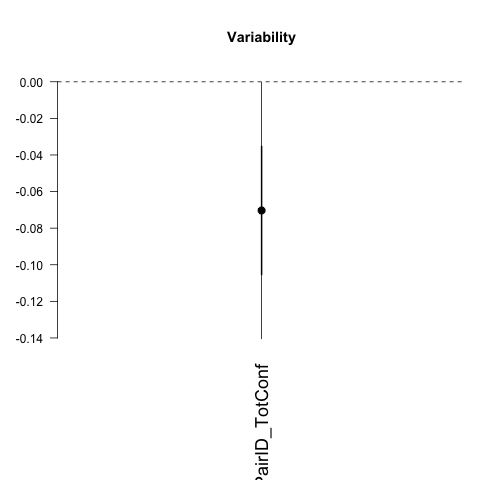

In [23]:
%%R
title_plot = "Variability"

ModelConsistency1 <- glm(variability ~ PairID_TotConf, data=pairID_state, family=binomial(link="logit"))

coefplot(ModelConsistency1,intercept=FALSE,vertical = FALSE,  col.pts='black', cex.var=1.5, cex.pts=2, mar = c(8,4,5,1) ,main=title_plot)
summary(ModelConsistency1)

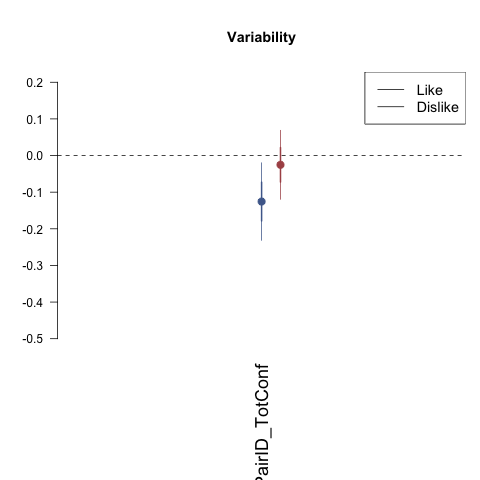

In [24]:
%%R

title_plot = "Variability"

ModelConsistency1_L <- glm(variability ~ PairID_TotConf, data=pairID_state_like, family=binomial(link="logit"))
ModelConsistency1_D <- glm(variability ~ PairID_TotConf, data=pairID_state_dislike, family=binomial(link="logit"))

coefplot(ModelConsistency1_L,intercept=FALSE,vertical = FALSE,  col.pts='#4F6A9A', cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),ylim=c(-0.5, 0.2) ,main=title_plot)
coefplot(ModelConsistency1_D,intercept=FALSE,vertical = FALSE,add=TRUE,  col.pts='#AC5255', cex.var=1.5, cex.pts=2, mar = c(8,4,5,1) ,main=title_plot)

legend("topright",  legend=c("Like", "Dislike"), lty=1:1, cex=1.2)

In [25]:
%%R
print("---- Like -------")
summary(ModelConsistency1_L)

[1] "---- Like -------"

Call:
glm(formula = variability ~ PairID_TotConf, family = binomial(link = "logit"), 
    data = pairID_state_like)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6819  -0.4800  -0.4501  -0.4276   2.2884  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -2.18205    0.07811 -27.935   <2e-16 ***
PairID_TotConf -0.12565    0.05286  -2.377   0.0175 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1205.6  on 1821  degrees of freedom
Residual deviance: 1200.1  on 1820  degrees of freedom
AIC: 1204.1

Number of Fisher Scoring iterations: 5



In [27]:
%%R
print("---- Dislike -------")
summary(ModelConsistency1_D)

[1] "---- Dislike -------"

Call:
glm(formula = variability ~ PairID_TotConf, family = binomial(link = "logit"), 
    data = pairID_state_dislike)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6096  -0.5678  -0.5607  -0.5543   1.9903  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -1.75829    0.06618 -26.568   <2e-16 ***
PairID_TotConf -0.02533    0.04703  -0.539     0.59    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1521.8  on 1821  degrees of freedom
Residual deviance: 1521.6  on 1820  degrees of freedom
AIC: 1525.6

Number of Fisher Scoring iterations: 4



## 3.Variability like vs dislike

Presented the mean variability per participant and each condition. No significant different per condition.

------------------------------------------------------------------

Variability: MeanL = 0.10295297287165048; MeanD = 0.14717815943111862; [Like - Dislike] =  -0.04422518655946814; t =  -1.75 ; p-value =0.09020357622214728


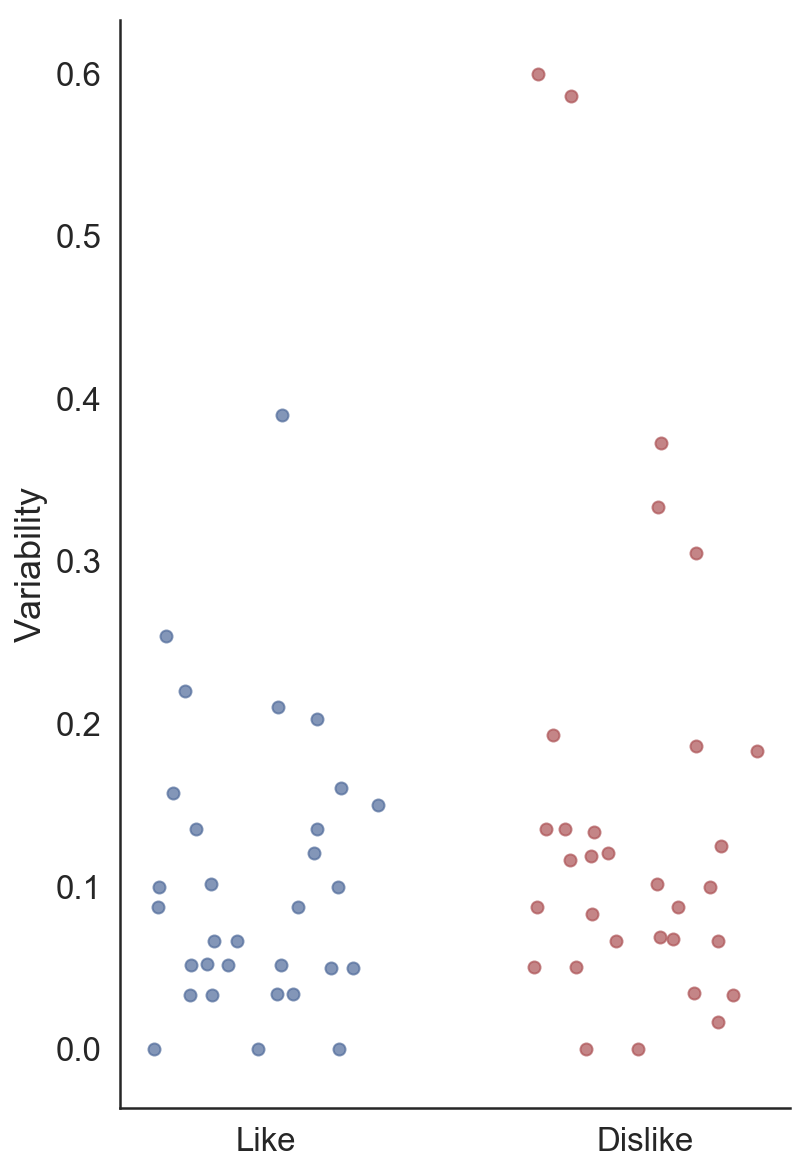

In [28]:
variability_part_like = []
variability_part_dislike =  []

for p in participants:
    variability_part_like.append(pairID_state_like.loc[(pairID_state_like['Part'] == p)].variability.mean())
    variability_part_dislike.append(pairID_state_dislike.loc[(pairID_state_dislike['Part'] == p)].variability.mean())


# t-TEST

diff = mean(variability_part_like) - mean(variability_part_dislike)
[s, p] = stats.ttest_rel(variability_part_like,variability_part_dislike)
print ("Variability: MeanL = "+ str(mean(variability_part_like))+ "; MeanD = "+ str(mean(variability_part_dislike))+"; [Like - Dislike] =  " + str(diff) +"; t =  " + str(round(s,2)) + " ; p-value =" + str(p) )

    
# PLOT LIKE AND DISLIKE VARIABILITY
    
# Set seaborn style for the plot
fig = plt.figure(figsize=[6,10])
sns.set(style='white',font_scale=1.5)
jittr = np.random.uniform(low=-0.3,high=0.3,size=len(variability_part_like))    
plt.scatter([1]*len(variability_part_like)+jittr, variability_part_like, c='#4F6A9A', alpha=0.7,label="Like")
plt.scatter([2]*len(variability_part_dislike)+jittr, variability_part_dislike, c='#AC5255', alpha=0.7,label="Dislike")
#legend(loc = 'best')
plt.xticks([1, 2,], ['Like', 'Dislike'])
plt.ylabel("Variability")
sns.despine()

    
#df = pd.DataFrame({'DVal':absDV, 'DGazw':absDG, 'RT':rts,'DEv':Dev_a})
#correl_plot(df,'DVal', "|DVal|",'DEv','|DEvidence|')

## 4.Relationship variability and confidence in choice

We observe a difference in relationship between variability and choice confidence for like vs dislike: higher magnitude of the effect during like condition.
### In both cases we have that higher choice confidence leads to lower pair variability. In other words, we are more confident in trials with consistent choices.
----------------------------------------------------------------------------

In [29]:
TrialVarability = []
for p in participants:
    trial_number = data_exp1.loc[(data_exp1['Part'] == p)].TrialN.unique()
    for i in trial_number:
        # extract the PairID for this particular trial 
        trial_pairID = data_exp1.loc[(data_exp1['Part'] == p) & (data_exp1['TrialN'] == i)].PairID.values[0]
        trial_blockCond = data_exp1.loc[(data_exp1['Part'] == p) & (data_exp1['TrialN'] == i)].BlockCond.values[0]
        trial_variablty = pairID_state.loc[(pairID_state['PairID'] == trial_pairID) & (pairID_state['Part'] == p) & (pairID_state['Block'] == trial_blockCond)].variability.values
        if len(trial_variablty)==1:
            TrialVarability.append(trial_variablty[0])
        else:
            TrialVarability.append(np.nan)


In [30]:
data_all = data_exp1
data_all['PairVariability'] = TrialVarability

In [31]:
data_all_like = data_all.loc[(data_all['BlockCond'] == 1) ]
data_all_dislike = data_all.loc[(data_all['BlockCond'] == 2)]

In [32]:
%R  -i data_all_like -i data_all_dislike

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


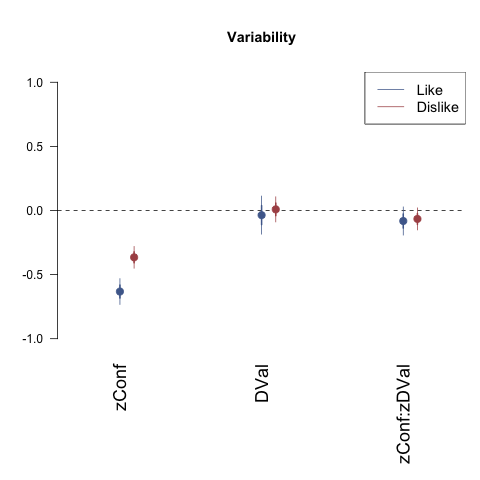

In [57]:
%%R
title_plot = "Variability"

ModelVariability1_L <- glm(PairVariability ~ zConf + DVal + zConf:zDVal, data=data_all_like, family=binomial(link="logit"))
ModelVariability1_D <- glm(PairVariability ~ zConf + zDVal + zConf:zDVal, data=data_all_dislike, family=binomial(link="logit"))

coefplot(ModelVariability1_L,intercept=FALSE,vertical = FALSE,  col.pts='#4F6A9A', cex.var=1.5, cex.pts=2, mar = c(8,4,5,1),ylim=c(-1, 1) ,main=title_plot)
coefplot(ModelVariability1_D,intercept=FALSE,vertical = FALSE,add=TRUE,  col.pts='#AC5255', cex.var=1.5, cex.pts=2, mar = c(8,4,5,1) ,main=title_plot)

legend("topright",  legend=c("Like", "Dislike"),col=c('#4F6A9A', '#AC5255'), lty=1:1, cex=1.2)

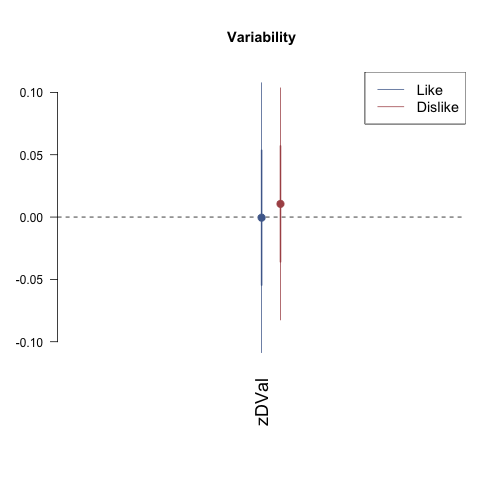

In [56]:
%%R
title_plot = "Variability"

ModelVariability1_L <- glm(PairVariability ~  zDVal , data=data_all_like, family=binomial(link="logit"))
ModelVariability1_D <- glm(PairVariability ~  zDVal , data=data_all_dislike, family=binomial(link="logit"))

coefplot(ModelVariability1_L,intercept=FALSE,vertical = FALSE,  col.pts='#4F6A9A', cex.var=1.5, cex.pts=2, mar = c(8,4,5,1) ,main=title_plot)
coefplot(ModelVariability1_D,intercept=FALSE,vertical = FALSE,add=TRUE,  col.pts='#AC5255', cex.var=1.5, cex.pts=2, mar = c(8,4,5,1) ,main=title_plot)

legend("topright",  legend=c("Like", "Dislike"),col=c('#4F6A9A', '#AC5255'), lty=1:1, cex=1.2)

## 5.Logistic regression Choice ~ DValue has bigger slope in trials with consistent responses

In [45]:
HVar_slopes_like = []
LVar_slopes_like = []

HVar_slopes_dislike = []
LVar_slopes_dislike = []


for p in participants:
    data_part = data_all.loc[(data_exp1['Part'] == p)]
    
    ## For Like block
    HVar_data_like = data_part.loc[(data_part['BlockCond'] == 1) & (data_part['PairVariability'] == 1)]
    LVar_data_like = data_part.loc[(data_part['BlockCond'] == 1) & (data_part['PairVariability'] == 0)]
    
    print ('Like  :  Participant: ' + str(p) + ' Number of trials: HV trials: ' + str(len(HVar_data_like)) + ' / LV trials:' + str(len(LVar_data_like)))
    
    if (len(HVar_data_like)>0) & (len(LVar_data_like)>0):
        logit = sm.Logit(HVar_data_like['Choice'], HVar_data_like['zDVal'],missing='drop')
        result = logit.fit(disp=0)
        HVar_slope_like1 = result.params.values[0]
    
        logit = sm.Logit(LVar_data_like['Choice'], LVar_data_like['zDVal'],missing='drop')
        result = logit.fit(disp=0)
        LVar_slope_like1 = result.params.values[0]
    
        HVar_slopes_like.append(HVar_slope_like1)
        LVar_slopes_like.append(LVar_slope_like1)
    else:
        # If we are missing one of the slopes (High or Low variability, mostly high) due to lack of 
        HVar_slopes_like.append(np.nan)
        LVar_slopes_like.append(np.nan)
    
    # For dislike block
    HVar_data_dislike = data_part.loc[(data_part['BlockCond'] == 2) & (data_part['PairVariability'] == 1)]
    LVar_data_dislike = data_part.loc[(data_part['BlockCond'] == 2) & (data_part['PairVariability'] == 0)]
    
    print ('Dislike  :  Participant: ' + str(p) + ' Number of trials: HV trials: ' + str(len(HVar_data_dislike)) + ' / LV trials:' + str(len(LVar_data_dislike)))
    
    
    if (len(HVar_data_dislike)>0) & (len(LVar_data_dislike)>0):
        logit = sm.Logit(HVar_data_dislike['Choice'], HVar_data_dislike['zDVal'],missing='drop')
        result = logit.fit(disp=0)
        HVar_slope_dislike1 = result.params.values[0]
    
        logit = sm.Logit(LVar_data_dislike['Choice'], LVar_data_dislike['zDVal'],missing='drop')
        result = logit.fit(disp=0)
        LVar_slope_dislike1 = result.params.values[0]
    
        HVar_slopes_dislike.append(HVar_slope_dislike1)
        LVar_slopes_dislike.append(LVar_slope_dislike1)
    else:
        # If we are missing one of the slopes (High or Low variability, mostly high) due to lack of 
        HVar_slopes_dislike.append(np.nan)
        LVar_slopes_dislike.append(np.nan)



Like  :  Participant: 1 Number of trials: HV trials: 12 / LV trials:106
Dislike  :  Participant: 1 Number of trials: HV trials: 14 / LV trials:104
Like  :  Participant: 3 Number of trials: HV trials: 4 / LV trials:114
Dislike  :  Participant: 3 Number of trials: HV trials: 12 / LV trials:106
Like  :  Participant: 4 Number of trials: HV trials: 4 / LV trials:116
Dislike  :  Participant: 4 Number of trials: HV trials: 14 / LV trials:106
Like  :  Participant: 5 Number of trials: HV trials: 6 / LV trials:108
Dislike  :  Participant: 5 Number of trials: HV trials: 0 / LV trials:120
Like  :  Participant: 8 Number of trials: HV trials: 10 / LV trials:104
Dislike  :  Participant: 8 Number of trials: HV trials: 10 / LV trials:108
Like  :  Participant: 9 Number of trials: HV trials: 14 / LV trials:102
Dislike  :  Participant: 9 Number of trials: HV trials: 4 / LV trials:114
Like  :  Participant: 10 Number of trials: HV trials: 16 / LV trials:102
Dislike  :  Participant: 10 Number of trials: HV t

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### However, notice that some in some participants, the number of trials with high variability (flip) is much lower than the ones with low variability (consistent choices) 

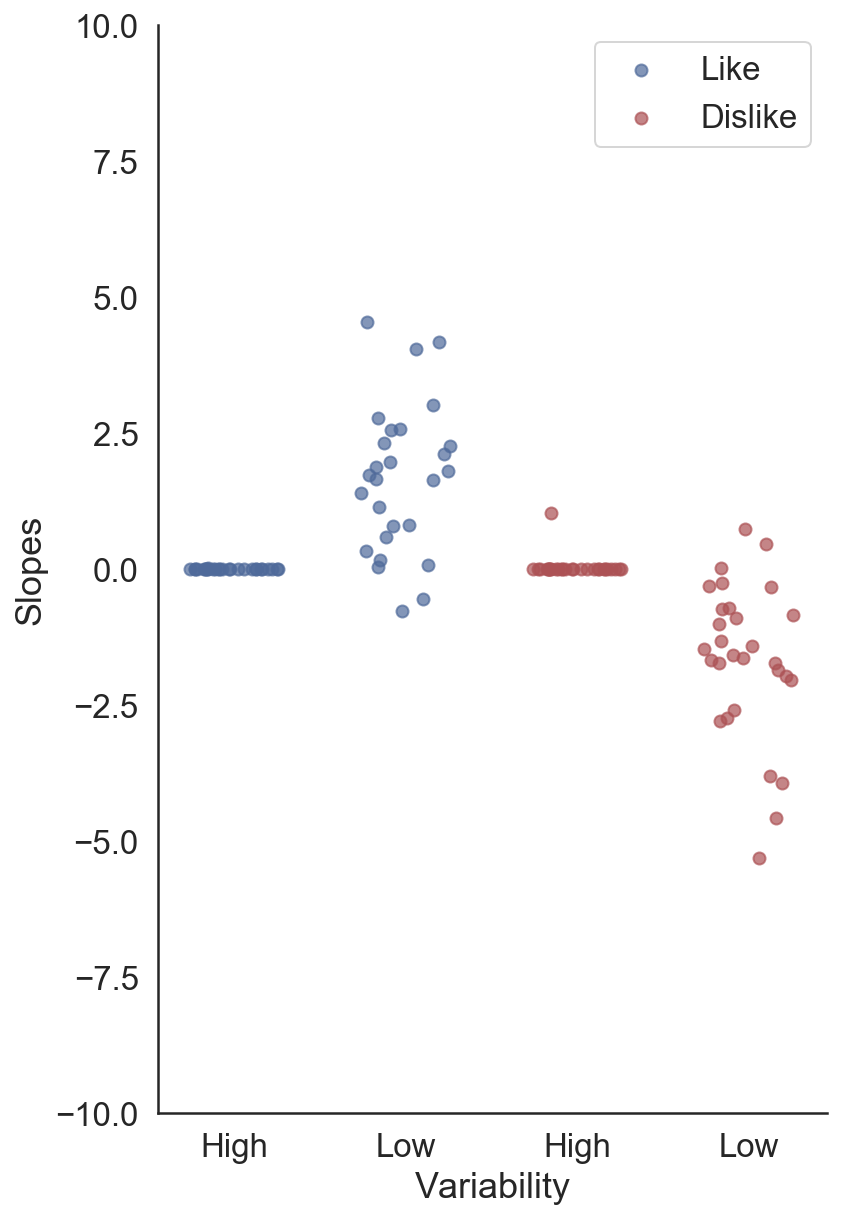

In [35]:
ttest_like_dislike(HVar_slopes_like,LVar_slopes_like,HVar_slopes_dislike,LVar_slopes_dislike,'Slopes',(-10,10))

Slopes of the logistic regression Choice ~ zDValue

<a id='ImpPkg'></a>
Import Packages
------------------------------------------

In [2]:
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame as DF

import seaborn as sns
sns.set(color_codes=True)
#np.random.seed(sum(map(ord, "distributions")))
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # packages for the logistic regression function to plot the logistic regression 
import scipy
from scipy import stats, integrate
from scipy.stats import mode
from scipy.stats.stats import pearsonr # Pearson's correlation
from copy import copy as copy
import operator as operator
import pylab
import statsmodels.api as sm

# Plotting tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%pylab inline
figsize(5, 5)

import glob

import os
# Added to avoid OMP:error#15
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy', 'pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
import rpy2

%load_ext rpy2.ipython
# Set up interface with R
# Make it easy to set and find values in a multi-index DF
idx = pd.IndexSlice
# Set up interface with R
%config InlineBackend.figure_format = 'retina'
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)


<a id='LoadFunc'></a>
# Defining Functions
---------------------------------------------------------------------

#### Taken from Folke et al. (2016)

### Plot distributions

In [4]:
def participant_densities(data, var, xlim=(0,100), rug=True):
    # a counter that tells us where a given participant's data should be plotted
    order = 1

    # a list of all the participants in the dataset
    participants = data.loc[:, 'Part'].unique()

    # defining the figure size
    sns.set_style('white')
    fig = figure(figsize=(15,70))

    for x in participants:
        # defining the sub figures
            sub={}
            sub['%s' % x] = plt.subplot(len(participants)/2, 3, order)
            sns.kdeplot(data.loc[data['Part'] == x, var].values, ax = sub['%s' % x], shade=True)
            #if rug==True:
            #    sns.rugplot(data.loc[data['Part'] == x, var].values, ax = sub['%s' % x])
            sub['%s' % x].set_title('participant %s' % x)
            #sub['%s' % x].set_xlim(xlim)
            order += 1

### Split variable into participantwise quantiles

In [5]:
def parsplit(DF, input, quantiles):
    qvalues = pd.qcut(DF[input], quantiles, labels = range(1, quantiles+1))
    return qvalues

### Full simple logistic graph

In [6]:
def logisticplot_all (moderator, modhigh, modlow, data, xaxis='zDV', yaxis='G_choice', ylab='P(Chose Reference Item)', xlab='DV (Z-score)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='SubNo'):
    
    sns.set(font_scale=1.5, style='white')
    fig = figure(figsize=(8,7))
    fig.set_facecolor('white')
    
    # defining the sigmoid function
    def model(x):
        y = 1 / (1 + np.exp(-x))
        return y
    
    sub = plt.subplot()


    #run the classifier
    clf = linear_model.LogisticRegression(C=1e5)

    # Paula used these dictionaries to store the values of the predictive lines for all the participants.
    logit_low = {}
    logit_high = {}

    # I think this defines the problem space
    X_test = np.linspace(-5,10,300)

    # fitting the predictive logistic model for the low_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data.loc[data[(data[moderator]==0)].index, xaxis][:, np.newaxis],
            data.loc[data[(data[moderator]==0)].index, yaxis])
    logit_low = model(X_test*clf.coef_ + clf.intercept_).ravel()

    print ('Low measure:logit coef =',clf.coef_, '; Intercept: ', clf.intercept_)


    # fitting the predictive logistic model for the high_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data.loc[data[(data[moderator]==1)].index, xaxis][:, np.newaxis],
            data.loc[data[(data[moderator]==1)].index, yaxis])
    logit_high = model(X_test * clf.coef_ + clf.intercept_).ravel()
    
    print ('high measure:logit coef =',clf.coef_, '; Intercept: ', clf.intercept_)

    
    
    #Plotting the predictive lines
    line_high = sub.plot(X_test, logit_high, color=modhighcol, linewidth=5, label=modhigh, zorder=6)
    line_low = sub.plot(X_test, logit_low, color=modlowcol, linewidth=5, label=modlow, zorder=5)


    #Plotting the binned data
    data['DVBin2'] = data.groupby(parvar).apply(parsplit, input=xaxis, quantiles=4).values
    
    # determine the x coordinates
    x_cords= data.groupby('DVBin2')[xaxis].mean()
    
    # determine low y coordinates
    y_cords_low = data.loc[(data[moderator]==0), :].groupby('DVBin2')[yaxis].mean().values
    
    # determine low y standard errors
    test = pd.DataFrame(data.loc[(data[moderator]==0), :].groupby(['DVBin2', parvar])[yaxis].mean()).reset_index()
    y_low_error = test.groupby('DVBin2')[yaxis].std()/np.sqrt(len(test[parvar].unique()))
    
    
    # determine high y coordinates
    y_cords_high = data.loc[(data[moderator]==1), :].groupby('DVBin2')[yaxis].mean().values
    
    # determine high y standard errors
    test2 = pd.DataFrame(data.loc[data[moderator]==1, :].groupby(['DVBin2', parvar])[yaxis].mean()).reset_index()
    y_high_error = test2.groupby('DVBin2')[yaxis].std()/np.sqrt(len(test[parvar].unique()))
    
    # plot the low points
    plt.scatter(x_cords, y_cords_low, c=modlowcol, marker='D', s=60, zorder=1)
    # plot low error bars
    plt.errorbar(x_cords, y_cords_low, yerr=y_low_error, fmt='o', zorder=3, c=modlowcol)
    
    # plot the high points
    plt.scatter(x_cords, y_cords_high, c=modhighcol, marker='o', s=60, zorder=2)
    # plot high error bars
    plt.errorbar(x_cords, y_cords_high, yerr=y_high_error, fmt='o', zorder=4, c=modhighcol)
    
    
    # Set Labels
    sub.set_ylabel(ylab, fontsize=30)
    sub.set_xlabel(xlab, fontsize=30)

    # Set Ticks
    sub.set_xticks((-5,-3,-1,1,3,5))
    sub.set_yticks((0,0.25,0.5,0.75,1))
    sub.tick_params(axis='both', which='major', labelsize=20)

    # Set Limits
    sub.set_ylim(-0.01, 1.01)
    sub.set_xlim(-5, 5)

    # Set Title
    if title == 'empty':
        sub.set_title('')
    else:
        sub.set_title(title)
    
    sub.legend(loc=0, prop={'size':20})
    sns.despine()

### Full simple logistic graph (no bins)

In [7]:
def logisticplot_simpl (moderator, modhigh, modlow, data, xaxis='zDV', yaxis='G_choice', ylab='P(Chose Reference Item)', xlab='DV (Z-score)',
                 modhighcol='#000000', modlowcol='#AAAAAA', title='empty', parvar='SubNo'):
    
    sns.set(font_scale=1.5, style='white')
    fig = figure(figsize=(8,7))
    fig.set_facecolor('white')
    
    # defining the sigmoid function
    def model(x):
        y = 1 / (1 + np.exp(-x))
        return y
    
    sub = plt.subplot()


    #run the classifier
    clf = linear_model.LogisticRegression(C=1e5)

    # Paula used these dictionaries to store the values of the predictive lines for all the participants.
    logit_low = {}
    logit_high = {}

    # I think this defines the problem space
    X_test = np.linspace(-5,10,300)

    # fitting the predictive logistic model for the low_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data.loc[data[(data[moderator]==0)].index, xaxis][:, np.newaxis],
            data.loc[data[(data[moderator]==0)].index, yaxis])
    logit_low = model(X_test*clf.coef_ + clf.intercept_).ravel()
    print ('Low measure coef',clf.coef_)
    
    # fitting the predictive logistic model for the high_confidence trials, for a participant specified by x
    # first I specify the value difference right - left, then I specify the choices, left or right
    clf.fit(data.loc[data[(data[moderator]==1)].index, xaxis][:, np.newaxis],
            data.loc[data[(data[moderator]==1)].index, yaxis])
    logit_high = model(X_test * clf.coef_ + clf.intercept_).ravel()
    print ('High measure coef',clf.coef_)



    #Plotting the predictive lines
    line_high = sub.plot(X_test, logit_high, color=modhighcol, linewidth=5, label=modhigh, zorder=6)
    line_low = sub.plot(X_test, logit_low, color=modlowcol, linewidth=5, label=modlow, zorder=5) 
    
    # Set Labels
    sub.set_ylabel(ylab, fontsize=30)
    sub.set_xlabel(xlab, fontsize=30)

    # Set Ticks
    sub.set_xticks((-5,-3,-1,1,3,5))
    sub.set_yticks((0,0.25,0.5,0.75,1))
    sub.tick_params(axis='both', which='major', labelsize=20)

    # Set Limits
    sub.set_ylim(-0.01, 1.01)
    sub.set_xlim(-5, 5)

    # Set Title
    if title == 'empty':
        sub.set_title('')
    else:
        sub.set_title(title)
    
    sub.legend(loc=0, prop={'size':20})
    sns.despine()

### Regression Coefficients Plot

In [8]:
def Coefpresplot(regtable, intercept=False, title='Regression Coefficients', size='big', ylimits=(), ymultiple=0.5, ticklabsize=25, n_ET_predictors = 0):

    # Import itertools so that we can iterate through the colours
    import itertools
    
    # Import locators so that we can tidy up the yaxis
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    
    # rounding function to get edges to even 0.5 values
    def round_to(n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision

    def round_to_5(n):
        return round_to(n, 0.5)

    # Set seaborn style for the plot
    sns.set(style='white')
    
    # Generate the figure
    if size=='big':
        fig = plt.figure(figsize=[20,8])
    elif size=='long':
        fig = plt.figure(figsize=[20,4])
    elif size=='narrow':
        fig = plt.figure(figsize=[10,4])
        
    fig.suptitle(title, fontsize=20)
    gs = GridSpec(1,1,bottom=0.18,left=0.18,right=0.82)
    ax = fig.add_subplot(gs[0,0])
    
    # Set axis limits based on whether to include the intercept or not    
    if intercept == True:
        XLim = (0.75, len(regtable.columns) + 0.25)
        YLim = (round_to_5(regtable.loc['CImin', :].min()-0.1), round_to_5(regtable.loc['CImax', :].max()+0.2))
    else:
        XLim = (0.75, len(regtable.columns) - 0.75)
        YLim = (round_to_5(regtable.loc['CImin', regtable.columns[1]:].min()-0.2), round_to_5(regtable.loc['CImax', regtable.columns[1]:].max()+0.2))
    if ylimits != ():
        YLim = ylimits
    ax.set_xlim(XLim)
    ax.set_ylim(YLim)
    
    # Draw a line through the 0-value on the y-axis
    line = ax.plot(XLim, [0, 0], color='black', ls='--', alpha = 0.5, lw=3)
    
    
    # If intercept is true, plot the coefficient for the intercept
    if intercept == True:
        Coefficients = regtable.columns
    else:
        Coefficients = regtable.columns[1:]
        
    # Determine the colours for the coefficients based on the n_ET_variable
    n_predictors = len(Coefficients)
    n_non_ET_predictors = n_predictors - n_ET_predictors
    
    colourlist = ['#000000'] * n_non_ET_predictors + ['#03719c'] * n_ET_predictors
    
        
    # Plot all the coefficients with 95% CI
    position = 0
    for Coefficient in Coefficients:
        position += 1
        ax.plot(position, regtable.loc['coefficient', Coefficient], marker='o', ms=8, color=colourlist[position-1],)
        ax.errorbar(position, regtable.loc['coefficient', Coefficient],
                    yerr=regtable.loc['se', Coefficient]*1.96, lw=2, color=colourlist[position-1])

    # Setting the x-axis major tick's location
    ax.set_xticks(range(1, position+1))
    
    # set the y-axis major tick position
    ax.yaxis.set_major_locator(MultipleLocator(ymultiple))


    # Setting the x-axis major tick's label
    if intercept == True:
        ax.set_xticklabels(regtable.columns, rotation=40)
    else: 
        ax.set_xticklabels(regtable.columns[1:], rotation=40)
    
    ax.tick_params(axis='both', which='major', labelsize=ticklabsize)
    ax.set_ylabel('Fixed Effects Coefficients', fontsize=18)
    
    # Autoformats the ticklabels for the xaxis
    fig.autofmt_xdate()
    
    sns.despine()

In [9]:
def Coefpresplot2(regtable,regtable2, intercept=False, title='Regression Coefficients', size='big', ylimits=(), ymultiple=0.5, ticklabsize=25, n_ET_predictors = 0):

    # Import itertools so that we can iterate through the colours
    import itertools
    
    # Import locators so that we can tidy up the yaxis
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    
    # rounding function to get edges to even 0.5 values
    def round_to(n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision

    def round_to_5(n):
        return round_to(n, 0.5)

    # Set seaborn style for the plot
    sns.set(style='white')
    
    # Generate the figure
    if size=='big':
        fig = plt.figure(figsize=[20,8])
    elif size=='long':
        fig = plt.figure(figsize=[20,4])
    elif size=='narrow':
        fig = plt.figure(figsize=[10,4])
        
    fig.suptitle(title, fontsize=20)
    gs = GridSpec(1,1,bottom=0.18,left=0.18,right=0.82)
    ax = fig.add_subplot(gs[0,0])
    

    # Set axis limits based on whether to include the intercept or not    
    
       
    
    if intercept == True:
        
        XLim = (0.75, len(regtable.columns) + 0.25)
        
        #Determine the Ymax and Ymin for both regresions results
        if round_to_5(regtable.loc['CImin', :].min()) < round_to_5(regtable2.loc['CImin', :].min()):
            Ymin = round_to_5(regtable.loc['CImin', :].min()-0.5)
        else :
            Ymin = round_to_5(regtable2.loc['CImin',:].min()-0.5)
        if round_to_5(regtable.loc['CImax', :].max()) > round_to_5(regtable2.loc['CImax', :].max()):
            Ymax = round_to_5(regtable.loc['CImax', :].max()+0.5)
        else :
            Ymax = round_to_5(regtable2.loc['CImax', :].max()+0.5)      

        YLim = (Ymin, Ymax)    
    else:
        XLim = (0.75, len(regtable.columns) - 0.75)
        
        #Determine the Ymax and Ymin for both regresions results
        if round_to_5(regtable.loc['CImin', regtable.columns[1]:].min()) < round_to_5(regtable2.loc['CImin', regtable.columns[1]:].min()):
            Ymin = round_to_5(regtable.loc['CImin', regtable.columns[1]:].min()-0.5)
        else :
            Ymin = round_to_5(regtable2.loc['CImin',regtable.columns[1]:].min()-0.5)
        if round_to_5(regtable.loc['CImax', regtable.columns[1]:].max()) > round_to_5(regtable2.loc['CImax', regtable.columns[1]:].max()):
            Ymax = round_to_5(regtable.loc['CImax', regtable.columns[1]:].max()+0.5)
        else :
            Ymax = round_to_5(regtable2.loc['CImax', regtable.columns[1]:].max()+0.5)      
        
        YLim = (Ymin, Ymax)
    
    if ylimits != ():
        YLim = ylimits
    ax.set_xlim(XLim)
    ax.set_ylim(YLim)
    
    # Draw a line through the 0-value on the y-axis
    line = ax.plot(XLim, [0, 0], color='black', ls='--', alpha = 0.5, lw=3)
    
    
    # If intercept is true, plot the coefficient for the intercept
    # both regtable should have the same regressors (and in the same order)

    if intercept == True:
        Coefficients = regtable.columns
 #       Coefficients2 = regtable2.columns
    else:
        Coefficients = regtable.columns[1:]
#        Coefficients2 = regtable2.columns[1:]
        
    # Determine the colours for the coefficients based on the n_ET_variable
    n_predictors = len(Coefficients)
    n_non_ET_predictors = n_predictors - n_ET_predictors
    
    colourlist = ['#000000'] * n_non_ET_predictors + ['#03719c'] * n_ET_predictors
    
        
    # Plot all the coefficients with 95% CI
    position = 0
    for Coefficient in Coefficients:
        position += 1
        ax.plot(position-0.1, regtable.loc['coefficient', Coefficient], marker='o', ms=8, color='blue',label = 'Like')
        ax.plot(position+0.1, regtable2.loc['coefficient', Coefficient], marker='X', ms=8, color='red', label = 'Dislike')


        ax.errorbar(position-0.1, regtable.loc['coefficient', Coefficient],
                    yerr=regtable.loc['se', Coefficient]*1.96, lw=2, color='blue')
        ax.errorbar(position+0.1, regtable2.loc['coefficient', Coefficient],
                    yerr=regtable2.loc['se', Coefficient]*1.96, lw=2, color='red')
        
        if position == 1:
            ax.legend( prop={'size': 20})

 
    # Setting the x-axis major tick's location
    ax.set_xticks(range(1, position+1))
    
    # set the y-axis major tick position
    ax.yaxis.set_major_locator(MultipleLocator(ymultiple))

    # Setting the x-axis major tick's label
    if intercept == True:
        ax.set_xticklabels(regtable.columns, rotation=40)
    else: 
        ax.set_xticklabels(regtable.columns[1:], rotation=40)
    
    ax.tick_params(axis='both', which='major', labelsize=ticklabsize)
    ax.set_ylabel('Fixed Effects Coefficients', fontsize=18)
    
    # Autoformats the ticklabels for the xaxis
    fig.autofmt_xdate()

    sns.despine()
    fig.savefig(str('SavedFigures/'+title +'.png'), dpi = 200 )

In [10]:
def Coefpresplot_bar(regtable, mixtable, intercept=False, barcol='#000000', title='Regression Coefficients', size='big', ylimits=(), ymultiple=0.5, ticklabsize=25, n_ET_predictors = 0 ):

    # Import itertools so that we can iterate through the colours
    import itertools
    
    # Import locators so that we can tidy up the yaxis
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    
    # rounding function to get edges to even 0.5 values
    def round_to(n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision

    def round_to_5(n):
        return round_to(n, 0.5)
            
    # Set seaborn style for the plot
    sns.set(style='white')
    
    # Generate the figure
    if size=='big':
        fig = plt.figure(figsize=[20,8])
    elif size=='long':
        fig = plt.figure(figsize=[20,4])
    elif size=='narrow':
        fig = plt.figure(figsize=[10,4])
        
    fig.suptitle(title, fontsize=20)
    gs = GridSpec(1,1,bottom=0.18,left=0.18,right=0.82)
    ax = fig.add_subplot(gs[0,0])
    
    # Set axis limits based on whether to include the intercept or not    
    if intercept == True:
        XLim = (0, len(regtable.columns) + 1)
        YLim = (round_to_5(np.min(mixtable)-0.2), round_to_5(np.max(mixtable)+0.2))
    else:
        XLim = (0, len(regtable.columns) )
        YLim = (round_to_5(np.min(mixtable)-0.2), round_to_5(np.max(mixtable)+0.2))
    if ylimits != ():
        YLim = ylimits
    ax.set_xlim(XLim)
    ax.set_ylim(YLim)
    
    # Draw a line through the 0-value on the y-axis
    line = ax.plot(XLim, [0, 0], color='black', ls='--', alpha = 0.5, lw=3)
    
    
    # If intercept is true, plot the coefficient for the intercept
    if intercept == True:
        Coefficients = regtable.columns
    else:
        Coefficients = regtable.columns[1:]
        
    # Determine the colours for the coefficients based on the n_ET_variable
    n_predictors = len(Coefficients)
    n_non_ET_predictors = n_predictors - n_ET_predictors
    
    colourlist = [barcol] * n_non_ET_predictors + ['#03719c'] * n_ET_predictors
    
        
    # Plot all the coefficients with 95% CI
    position = 0
    for Coefficient in Coefficients:
        position += 1
        ax.bar(position, regtable.loc['coefficient', Coefficient], width=0.8,color=colourlist[position-1],)
        ax.errorbar(position, regtable.loc['coefficient', Coefficient],
                    yerr=regtable.loc['se', Coefficient]*1.96, lw=2, color='#000000')
        
   # Plot dots for the individual coefficients
    coef_num = len(mixtable)
    for i in range(1,coef_num):
        part_coefs = mixtable[i]
        position_parts= np.full(len(part_coefs), i, dtype=int)
        jittr = np.random.uniform(low=-0.5,high=0.5,size=len(part_coefs))/2
        ax.plot(position_parts+jittr, part_coefs, marker='o', ms=8, color='#000000',alpha=0.3,linestyle="None")

        

    # Setting the x-axis major tick's location
    ax.set_xticks(range(1, position+1))
    
    # set the y-axis major tick position
    ax.yaxis.set_major_locator(MultipleLocator(ymultiple))


    # Setting the x-axis major tick's label
    if intercept == True:
        ax.set_xticklabels(regtable.columns, rotation=40)
    else: 
        ax.set_xticklabels(regtable.columns[1:], rotation=40)
    
    ax.tick_params(axis='both', which='major', labelsize=ticklabsize)
    ax.set_ylabel('Regression Coefficients', fontsize=18)
    
    # Autoformats the ticklabels for the xaxis
    fig.autofmt_xdate()
    
    sns.despine()

In [11]:
def regtable(fix, fix_se, names):
    fixed_betas = DF(np.array(fix)); fixed_betas = fixed_betas.transpose(); fixed_betas.columns = names
    fixed_betas.loc[1] = np.array(fix_se)
    fixed_betas.loc[2] = fixed_betas.loc[0] - (fixed_betas.loc[1]*1.96)
    fixed_betas.loc[3] = fixed_betas.loc[0] + (fixed_betas.loc[1]*1.96)
    fixed_betas.index = ['coefficient', 'se', 'CImin', 'CImax']
    return fixed_betas

In [12]:
def ttest_like_dislike(HV_part_like, LV_part_like, HV_part_dislike, LV_part_dislike, measure,ylimits=(0,100)):
   # diff = mean(variability_part_like) - mean(variability_part_dislike)
   # [s, p] = stats.ttest_rel(variability_part_like,variability_part_dislike)
   # print (measure+ "MeanL = "+ str(mean(variability_part_like))+ "; MeanD = "+ str(mean(variability_part_dislike))+"; [Like - Dislike] =  " + str(diff) +"; t =  " + str(round(s,2)) + " ; p-value =" + str(p) )
        
    # PLOT LIKE AND DISLIKE VARIABILITY
        
    # Set seaborn style for the plot
    fig = plt.figure(figsize=[6,10])
    sns.set(style='white',font_scale=1.5)
    jittr = np.random.uniform(low=-0.3,high=0.3,size=len(variability_part_like))    
    p1 = plt.scatter([1]*len(HV_part_like)+jittr, HV_part_like, c='#4F6A9A', alpha=0.7,label="Like")
    p2 = plt.scatter([2]*len(LV_part_like)+jittr, LV_part_like, c='#4F6A9A', alpha=0.7,label="Like")
    p3 = plt.scatter([3]*len(HV_part_dislike)+jittr, HV_part_dislike, c='#AC5255', alpha=0.7,label="Dislike")
    p4 = plt.scatter([4]*len(LV_part_dislike)+jittr, LV_part_dislike, c='#AC5255', alpha=0.7,label="Dislike")
    
    plt.ylim(ylimits)
    
    #legend(loc = 'best')
    plt.xticks([1, 2,3,4], ['High', 'Low','High', 'Low'])
    plt.ylabel(measure)
    plt.xlabel('Variability')
    plt.legend((p1, p3), ('Like', 'Dislike'))
    sns.despine()


## [END]